In [22]:
import dolfinx as dlx
import numpy as np
import pyvista as pv
from mpi4py import MPI

from ls_prior import builder

pv.global_theme.jupyter_backend = "static" 

In [23]:
mpi_communicator = MPI.COMM_WORLD
mesh, *_ = dlx.io.gmshio.read_from_msh("left_atrium_surface.msh", mpi_communicator, rank=0, gdim=3)
num_vertices = mesh.geometry.x.shape[0]
mean_vector = np.zeros(num_vertices)

Info    : Reading 'left_atrium_surface.msh'...
Info    : 1 entity
Info    : 8843 nodes
Info    : 17444 elements
Info    : Done reading 'left_atrium_surface.msh'


In [24]:
prior_settings = builder.BilaplacianPriorSettings(
    mesh=mesh,
    mean_vector=mean_vector,
    kappa=0.1,
    tau=10,
    mpi_communicator=mpi_communicator,
)
prior_builder = builder.BilaplacianPriorBuilder(prior_settings)
bilaplace_prior = prior_builder.build()

In [25]:
test_vector_1 = np.ones_like(mean_vector)
test_vector_2 = 2*np.ones_like(mean_vector)
test_vector_3 = 3*np.ones_like(mean_vector)

cost = bilaplace_prior.evaluate_cost(test_vector_1)
grad = bilaplace_prior.evaluate_gradient(test_vector_2)
hvp = bilaplace_prior.evaluate_hessian_vector_product(test_vector_3)
sample = bilaplace_prior.generate_sample()

print(cost)
print(grad)
print(hvp)
print(sample)

43.55086777072737
[0.01689655 0.00941314 0.01084435 ... 0.01489044 0.02178221 0.01797319]
[0.02534482 0.01411971 0.01626652 ... 0.02233566 0.03267331 0.02695979]
[-0.24850201 -0.29627451 -0.21434231 ... -0.30869388 -0.357474
 -0.30391114]


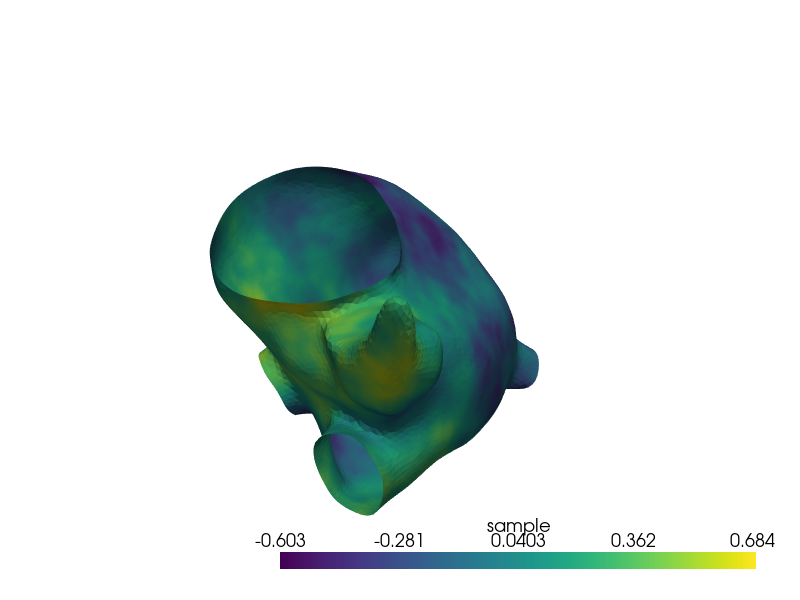

In [29]:
vertices = mesh.geometry.x
simplices = mesh.geometry.dofmap

pv_mesh = pv.PolyData.from_regular_faces(vertices, simplices)
pv_mesh.point_data["sample"] = sample
plotter = pv.Plotter()
plotter.add_mesh(pv_mesh, scalars="sample", cmap="viridis", show_edges=False, show_scalar_bar=True)
plotter.show(window_size=[800, 600])